#### Import required libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

####  Read outputs from the local model

In [ ]:
# Read the CSV file containing Y outputs
Y_data = pd.read_csv("Y_out.csv", header=None)

# Extract the first 6 columns (y1 to y6)
Y_values = Y_data.iloc[:, 0:6].values  # Shape: (num_rows, 6)

# Extract the input index from the 7th column (starting from 1 to 10)
input_index = Y_data.iloc[:, 6].values  # Shape: (num_rows,)

# Number of unique input sets#
num_samples = len(np.unique(input_index))  # Should be 10

# Number of time steps per input set (given that each set produces 60 rows)
time_steps_per_input = len(Y_values) // num_samples  # Should be 60

# Initialize an array to store time-averaged Y for each input set
Y_samples = np.zeros((num_samples, 6))  # Shape: (10, 6)

# Compute mean response for each input set
for i in range(1, num_samples + 1):  # Input index ranges from 1 to 10
    Y_samples[i - 1, :] = Y_values[input_index == i].mean(axis=0)

# Convert Y_samples into a NumPy array
Y_samples = np.array(Y_samples)  # Shape: (10, 6)

# Print shape to verify
print("Y_samples shape:", Y_samples.shape)  # Expected: (10, 6)


Y_samples shape: (10, 6)


#### Extract correcponsding input values from the input.txt file

In [18]:
# Load the input values (first five columns: Xa1, Xa2, Xe1, Xe2, Xe3)
X_inputs = np.loadtxt("input_new.txt", delimiter=",", usecols=[0, 1, 2, 3, 4])  # Shape: (10, 5)

# Extract the corresponding values
Xa1_vals, Xa2_vals, Xe1_vals, Xe2_vals, Xe3_vals = X_inputs[:, 0], X_inputs[:, 1], X_inputs[:, 2], X_inputs[:, 3], X_inputs[:, 4]

#### Extract dimensions of the input and output data

In [19]:
# Extract number of output dimensions (6 response variables: y1 to y6)
num_outputs = Y_samples.shape[1]
num_samples = X_inputs.shape[0]  # Should be 10

#### Create a PyMC model to estimate the parameters of the model

In [27]:
# Bayesian model
with pm.Model() as bayesian_model:
    # Aleatory variables (normally distributed priors)
    Xa1 = pm.Normal("Xa1", mu=0.5, sigma=0.1, shape=num_samples)  # Now sampled
    Xa2 = pm.Normal("Xa2", mu=0.5, sigma=0.1, shape=num_samples)

    # Epistemic variables (uniform priors for lack of knowledge)
    Xe1 = pm.Uniform("Xe1", lower=0.3, upper=0.4, shape=num_samples)
    Xe2 = pm.Uniform("Xe2", lower=0.4, upper=0.5, shape=num_samples)
    Xe3 = pm.Uniform("Xe3", lower=0.5, upper=0.6, shape=num_samples)

    # Define the expected mean function for Y
    # Ensure shape matches (10,6) for Y_samples
    mu_y = pm.Deterministic("mu_y", 
                             Xa1[:, None] + Xa2[:, None] + 
                             Xe1[:, None] + Xe2[:, None] + Xe3[:, None])  # Shape: (10,6)

    # Priors for output noise (uncertainty in model predictions)
    sigma_y = pm.HalfNormal("sigma_y", sigma=1, shape=num_outputs)

    # Likelihood: Y_samples are the observed system responses
    Y_obs = pm.Normal("Y_obs", mu=mu_y, sigma=sigma_y, observed=Y_samples)

#### Perform MCMC sampling

In [28]:
with bayesian_model:
    trace = pm.sample(2000, return_inferencedata=True, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Xa1, Xa2, Xe1, Xe2, Xe3, sigma_y]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 22 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [29]:
available_vars = list(trace.posterior.data_vars)  # Get all stored variables
print("Available variables in trace:", available_vars)

Available variables in trace: ['Xa1', 'Xa2', 'Xe1', 'Xe2', 'Xe3', 'sigma_y', 'mu_y']


#### Plot posterior distributions

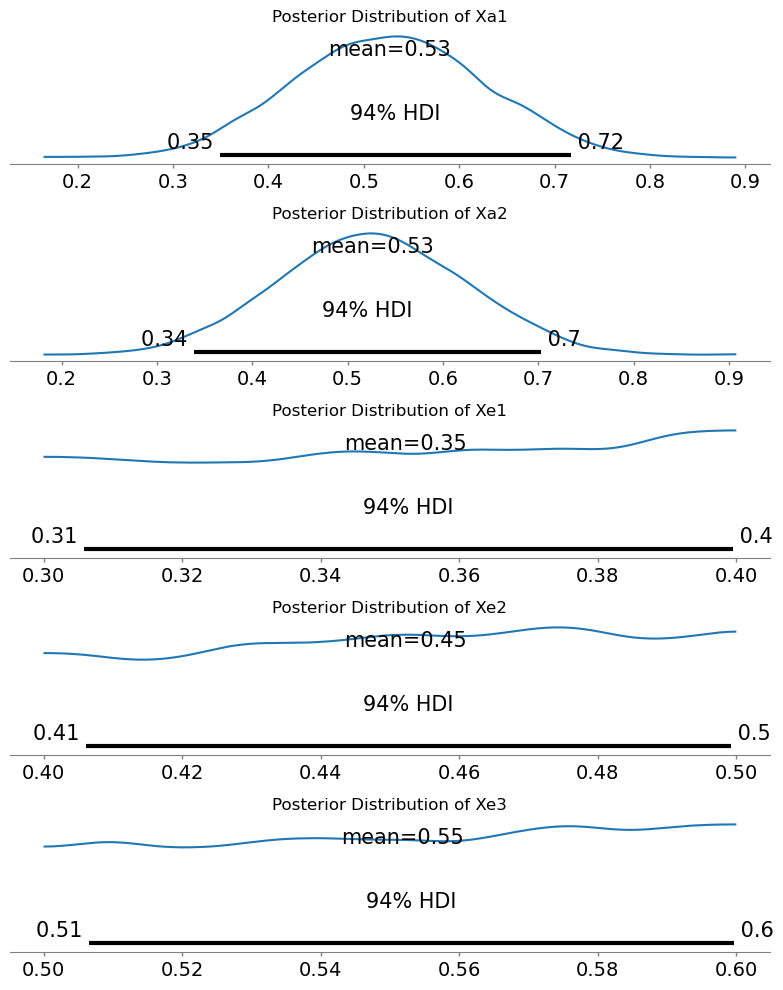

In [33]:
# Define variable names from the trace
input_var_names = ["Xa1", "Xa2", "Xe1", "Xe2", "Xe3"]

# Set number of variables to plot
num_vars = len(input_var_names)

# Create subplots with appropriate grid layout
fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(8, 2 * num_vars))  # One row per variable

# Loop over each variable and plot separately
for i, var in enumerate(input_var_names):
    az.plot_posterior(trace, var_names=[var], ax=axes[i])  # Assign each plot to a separate axis
    axes[i].set_title(f"Posterior Distribution of {var}", fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()